# 1 - Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


In [3]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [4]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [5]:
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)

p_i = np.count_nonzero(cell_pop_M, axis = (0,1))/200
print("Relative presence for each species: \n", p_i, '\n')

Relative presence for each species: 
 [0.05  0.765 0.08  0.275 0.18  0.515 0.01  0.71  0.34  1.    0.04  0.115
 0.02  0.72  0.72  0.335 0.69  0.17  0.03  0.005 0.01  0.28  0.035 0.67
 0.5   0.215 0.025 0.01  0.07  0.86  0.005 0.945 0.025 0.825 0.985 0.77
 0.37  0.085 0.065 0.44  0.96  0.105 0.79  0.04  0.385 0.045 0.23  0.425
 0.005 0.22  0.03  0.29  0.01  0.565 0.91  0.44  0.08  0.04  0.01  0.43
 0.755 0.005 0.015 0.28  0.345 0.845 0.955 0.93  0.015 0.48  0.045 0.175
 0.265 0.93  0.02  0.305 1.    0.295 0.22  0.78  0.045 0.06  0.305 0.695
 0.405 0.85  0.99  0.855 0.98  1.    0.02  0.035 0.005 0.055 0.04  0.03
 0.015 0.105 0.025 0.035 1.    0.685 0.26  0.52  0.25  0.99  0.95  0.87
 0.245 0.69  0.775 0.3   0.005 0.33  0.785 0.315 0.915 0.865 0.09  1.
 0.33  1.    0.285 0.18  0.24  0.77  0.01  0.735 0.01  0.215 0.12  0.905
 0.025 0.73  0.59  0.095 0.33  0.96  0.62  0.985 0.38  0.095 0.595 0.02
 0.005 0.305 0.445 0.22  0.83  0.005 0.53  0.005 0.19  0.775 0.13  0.975
 0.02  0.01  0.27  0.5

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [6]:
S_present = np.count_nonzero(cell_pop_M.reshape(200, 299), axis = (1))
C_0_over_S = np.mean((2*S_present - S)**2)/299
print(C_0_over_S)

21.32829431438127


## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


#### Lagrangian multipliers as functions of the constraints.

On the PDF we also show that starting from this Hamiltonian and imposing $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$, it is possible to obtain:

$$m_i = tanh(\lambda_i) $$

and inverting the system we find

$$ \lambda_i = tanh^{-1}(m_i) = \frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [7]:
m_i = 2*p_i - 1
print('Max and min values of m are:', m_i.max(), m_i.min())
eps = 0
l_i = np.arctanh(m_i- np.sign(m_i)*eps)
print('Max and min values of lambdas are:', l_i.max(),l_i.min())

Max and min values of m are: 1.0 -0.99
Max and min values of lambdas are: inf -2.6466524123622457


/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in arctanh
  after removing the cwd from sys.path.


From this value it is possible to see that there are some species with $m_i=1$, this means that they are present in every subplot. Since the Lagrangian multipliers are computed through $ \lambda_i = tanh^{-1}(m_i) $, it is normal that the $\lambda_i$ corresponding to the species with $m_i=1$ tend toward infinite. 
After removing these last values, here we check how the remaining ones are distributed.

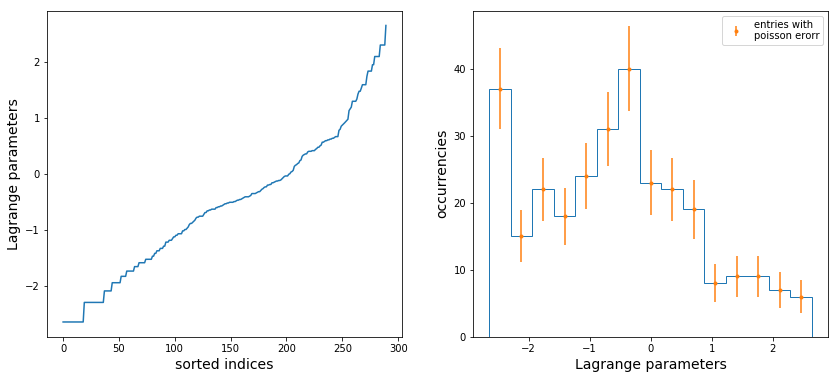

In [8]:
# first we remove from the plots the infinite eigenvalues
l_i_sorted = l_i[np.isfinite(l_i)]
# then we sort the remaining one for the first plot
l_i_sorted.sort()

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
# left panel
ax[0].plot(l_i_sorted)
ax[0].set_xlabel("sorted indices", fontsize = 14)
ax[0].set_ylabel("Lagrange parameters", fontsize = 14)
# right panel
counts, bin_extremes1, _ = ax[1].hist(l_i_sorted, bins = 15, histtype = 'step', density = False)
bin_centers1 = (bin_extremes1[1:] + bin_extremes1[:-1])/2
ax[1].errorbar(bin_centers1, counts, np.sqrt(counts), fmt = '.', label = 'entries with \npoisson erorr')
ax[1].set_xlabel("Lagrange parameters", fontsize = 14)
ax[1].set_ylabel("occurrencies", fontsize = 14)
plt.legend()
plt.show()

In these last two plots it is possible to see that there are more negative Lagrange parameters than positive ones. This is reasonable because in each subplot the number of absent species is greater than the number of present ones.

## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $\frac{<(S_+ - S_-)^2>_{exp}}{S} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model}}{S} = \frac{C_0(\vec{\sigma})}{S}$ with coupled parameter $\lambda_0 = K$

To initialize the Lagrange multipliers we extracting them from a gaussian distribution centered in 0.

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)}}{S} - \frac{<(S_+ - S_-)^2>_{exp}}{S}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

After some experiment we chosen to use only a fixed number of iteration as stopping criteria because using a specific acceptance rate as treshold led to a not converging algorithm.

In [9]:
def gradient(model_configs, exp_constraints):
    update1 = pairing_vec(model_configs) - exp_constraints[0]
    print("Model constraint C_0: ", pairing_vec(model_configs))
    print("Observed constraint C_0: ", exp_constraints[0])
    update2 = model_m(model_configs) - exp_constraints[1:]
    gradient = np.concatenate((update1[np.newaxis], update2))
    return gradient

def adam(grad, m, s, beta1=0.9, beta2=0.99, e=1e-8):
    m = beta1*m+(1-beta1)*grad
    s = beta2*s+(1-beta2)*(grad**2)
    m_c = m/(1-beta1)
    s_c = s/(1-beta2)
    # return new_m, new_s and adam_gradient
    return m, s, (m_c/np.sqrt(s_c+e))

In [10]:
def pairing(configs):
    return np.power(configs.sum(),2)/S

def pairing_vec(configs):
    Spm = configs.sum(axis=1)
    mean_Spm = Spm.mean()
    return np.power(mean_Spm,2)/S

def model_m(configs):
    # assuming configs have a shape of (n, S) with S = 299
    return configs.mean(axis=0)


def compute_energy(config, L_multipliers):
    """Computes the energy of a configuration."""
    model_pair = pairing(config) # C_0/S
    model_parameters = np.concatenate((model_pair[np.newaxis], config))
    return -np.dot(model_parameters[1:], L_multipliers[1:]) - model_parameters[0]*L_multipliers[0]


In [11]:
def METRO(lagrange_multipliers, M=1e4, N=1000):
    configs = []
    configuration = np.random.choice([+1,-1], size = 299)
    Spm = configuration.sum()
    flip_spins = np.random.randint(low = 0, high = 299, size = int(M))
    for index in flip_spins:
        if acceptance(configuration, lagrange_multipliers, index, Spm): 
            Spm = Spm -2*configuration[index]
            configuration[index] = -configuration[index]
            configs.append(configuration)
             
    return np.array(configs[-N:])

def acceptance(old, lagrange_multipliers, flipped_index, Spm):
    """Implements Metropolis choice."""
    dE = compute_dE(old, lagrange_multipliers, flipped_index, Spm)
    if  dE < 0:
        return True
    else:
        P = np.random.random()
        if P < np.exp(-dE):
            return True
        else:
            return False
        
def compute_dE(old, lagrange_multipliers, flipped_index, Spm):
    first_term = 4*lagrange_multipliers[0]/S*(old[flipped_index]*Spm -1)
    second_term = 2*lagrange_multipliers[flipped_index+1]*old[flipped_index]
    return  first_term + second_term
    


In [13]:
# Hyperparameters

# number of iterations
max_iter = 300

# learning rate
eta = 0.1

lagrange_multipliers = np.random.randn(300)
exp_constraints = np.concatenate((C_0_over_S[np.newaxis], m_i))
print(lagrange_multipliers[0]*exp_constraints[0])
mean_sq_loss = np.zeros(max_iter) # gradient square sum
Ks = np.zeros(max_iter)
lambdas_mean = np.zeros(max_iter)
m = 0; s=0

from tqdm import tnrange
for i in tnrange(max_iter):
    configs = METRO(lagrange_multipliers, M=1e6, N=5000)
    g = gradient(configs, exp_constraints)
    print("First component of g:", g[0])
    m, s, update = adam(g, m, s)
    print("First component of adams:", update[0])
    lagrange_multipliers = lagrange_multipliers - eta*update
    eta = eta*0.99
    Ks[i] = lagrange_multipliers[0]
    lambdas_mean[i] = lagrange_multipliers[1:].mean()
    print("K : ", Ks[i])
    mean_sq_loss[i] = np.power(g,2).sum()
    print("Squared gradient: ", mean_sq_loss[i], '\n')
    #break

-11.30880482782926


Model constraint C_0:  0.7525083612040134
Observed constraint C_0:  21.32829431438127
First component of g: -20.575785953177256
First component of adams: -0.9999999999881899
K :  -0.43022546768914066
Squared gradient:  890.3024675909664 

Model constraint C_0:  0.16387959866220736
Observed constraint C_0:  21.32829431438127
First component of g: -21.164414715719065
First component of adams: -1.347644481940043
K :  -0.2968086639770764
Squared gradient:  905.5919502589456 

Model constraint C_0:  0.030100334448160536
Observed constraint C_0:  21.32829431438127
First component of g: -21.29819397993311
First component of adams: -1.5739932900570979
K :  -0.14254158161858024
Squared gradient:  913.6725668068589 

Model constraint C_0:  0.0033444816053511705
Observed constraint C_0:  21.32829431438127
First component of g: -21.32494983277592
First component of adams: -1.7345366082149316
K :  0.025760332022853744
Squared gradient:  927.2929853704098 

Model constraint C_0:  0.03010033444816053

Model constraint C_0:  26.49163879598662
Observed constraint C_0:  21.32829431438127
First component of g: 5.16334448160535
First component of adams: 0.2896131554020095
K :  0.49061160221406824
Squared gradient:  157.79962623572442 

Model constraint C_0:  18.812709030100333
Observed constraint C_0:  21.32829431438127
First component of g: -2.515585284280938
First component of adams: 0.23968007785372192
K :  0.47391996478202
Squared gradient:  147.9876693224908 

Model constraint C_0:  10.117056856187292
Observed constraint C_0:  21.32829431438127
First component of g: -11.21123745819398
First component of adams: 0.11669433405043317
K :  0.4658744845883028
Squared gradient:  252.71134534401182 

Model constraint C_0:  8.03010033444816
Observed constraint C_0:  21.32829431438127
First component of g: -13.29819397993311
First component of adams: -0.012425990254870593
K :  0.4667226262629044
Squared gradient:  307.3814631279292 

Model constraint C_0:  8.698996655518394
Observed constrain

Model constraint C_0:  15.923076923076923
Observed constraint C_0:  21.32829431438127
First component of g: -5.4052173913043475
First component of adams: -0.10004269785683349
K :  0.520815613802335
Squared gradient:  165.19587504725897 

Model constraint C_0:  20.872909698996654
Observed constraint C_0:  21.32829431438127
First component of g: -0.4553846153846166
First component of adams: -0.09484952030589847
K :  0.5254621995420324
Squared gradient:  139.466875147929 

Model constraint C_0:  25.31438127090301
Observed constraint C_0:  21.32829431438127
First component of g: 3.9860869565217385
First component of adams: -0.04741789851064281
K :  0.5277619266994522
Squared gradient:  159.78838922495274 

Model constraint C_0:  21.94314381270903
Observed constraint C_0:  21.32829431438127
First component of g: 0.6148494983277608
First component of adams: -0.03695082856071337
K :  0.5295360891641184
Squared gradient:  132.51753990559394 

Model constraint C_0:  39.735785953177256
Observed 

Model constraint C_0:  17.82274247491639
Observed constraint C_0:  21.32829431438127
First component of g: -3.505551839464882
First component of adams: 0.05044071428390136
K :  0.45739225279422746
Squared gradient:  137.34839369917563 

Model constraint C_0:  11.642140468227424
Observed constraint C_0:  21.32829431438127
First component of g: -9.686153846153847
First component of adams: -0.04908032063594978
K :  0.45908362043960255
Squared gradient:  221.24107633136097 

Model constraint C_0:  25.31438127090301
Observed constraint C_0:  21.32829431438127
First component of g: 3.9860869565217385
First component of adams: -0.005305203548073086
K :  0.45926461597960516
Squared gradient:  165.14838922495272 

Model constraint C_0:  13.274247491638796
Observed constraint C_0:  21.32829431438127
First component of g: -8.054046822742475
First component of adams: -0.08384667619752663
K :  0.46209657436825113
Squared gradient:  202.28717022292815 

Model constraint C_0:  16.859531772575252
Obse

Model constraint C_0:  25.31438127090301
Observed constraint C_0:  21.32829431438127
First component of g: 3.9860869565217385
First component of adams: -0.10716153555210255
K :  0.530137144878434
Squared gradient:  156.54838922495276 

Model constraint C_0:  7.3879598662207355
Observed constraint C_0:  21.32829431438127
First component of g: -13.940334448160534
First component of adams: -0.24425935232284304
K :  0.5360583981739465
Squared gradient:  335.0724245265713 

Model constraint C_0:  14.130434782608695
Observed constraint C_0:  21.32829431438127
First component of g: -7.1978595317725755
First component of adams: -0.29707189690559394
K :  0.5431879002892601
Squared gradient:  194.2286818391293 

Model constraint C_0:  7.3879598662207355
Observed constraint C_0:  21.32829431438127
First component of g: -13.940334448160534
First component of adams: -0.41357586024841897
K :  0.5530141548127789
Squared gradient:  344.0324245265712 

Model constraint C_0:  23.040133779264213
Observed

Model constraint C_0:  24.163879598662206
Observed constraint C_0:  21.32829431438127
First component of g: 2.835585284280935
First component of adams: 0.4305317951567669
K :  0.5679352231689191
Squared gradient:  128.8600439044306 

Model constraint C_0:  15.923076923076923
Observed constraint C_0:  21.32829431438127
First component of g: -5.4052173913043475
First component of adams: 0.33244144961015304
K :  0.5622661845365962
Squared gradient:  151.59587504725897 

Model constraint C_0:  21.94314381270903
Observed constraint C_0:  21.32829431438127
First component of g: 0.6148494983277608
First component of adams: 0.307142680611985
K :  0.5570809355647072
Squared gradient:  131.9175399055939 

Model constraint C_0:  30.183946488294314
Observed constraint C_0:  21.32829431438127
First component of g: 8.855652173913043
First component of adams: 0.36950164002071606
K :  0.5509053092555957
Squared gradient:  230.60207542533078 

Model constraint C_0:  15.923076923076923
Observed constrai

Model constraint C_0:  10.866220735785953
Observed constraint C_0:  21.32829431438127
First component of g: -10.462073578595318
First component of adams: -0.20107039841088367
K :  0.5530584730146534
Squared gradient:  230.79448356394224 

Model constraint C_0:  13.274247491638796
Observed constraint C_0:  21.32829431438127
First component of g: -8.054046822742475
First component of adams: -0.267559284651982
K :  0.5562680373554887
Squared gradient:  209.68717022292816 

Model constraint C_0:  12.444816053511706
Observed constraint C_0:  21.32829431438127
First component of g: -8.883478260869564
First component of adams: -0.3362168842994724
K :  0.5602608669326703
Squared gradient:  222.41568601134213 

Model constraint C_0:  32.779264214046826
Observed constraint C_0:  21.32829431438127
First component of g: 11.450969899665555
First component of adams: -0.17929335254100615
K :  0.562368818543977
Squared gradient:  268.06421164304663 

Model constraint C_0:  20.872909698996654
Observed 

Model constraint C_0:  26.49163879598662
Observed constraint C_0:  21.32829431438127
First component of g: 5.16334448160535
First component of adams: 0.18771594907265826
K :  0.5653148039441627
Squared gradient:  157.2796262357244 

Model constraint C_0:  16.859531772575252
Observed constraint C_0:  21.32829431438127
First component of g: -4.468762541806019
First component of adams: 0.12315152338684819
K :  0.5642756074822858
Squared gradient:  145.6693386550486 

Model constraint C_0:  18.812709030100333
Observed constraint C_0:  21.32829431438127
First component of g: -2.515585284280938
First component of adams: 0.08507970055426184
K :  0.5635648539637877
Squared gradient:  128.3876693224908 

Model constraint C_0:  10.117056856187292
Observed constraint C_0:  21.32829431438127
First component of g: -11.21123745819398
First component of adams: -0.040460335925549894
K :  0.5638994784708328
Squared gradient:  294.4713453440118 

Model constraint C_0:  25.31438127090301
Observed constra

Model constraint C_0:  15.013377926421406
Observed constraint C_0:  21.32829431438127
First component of g: -6.314916387959865
First component of adams: -0.20571776728285487
K :  0.5471070075909413
Squared gradient:  161.3376689869241 

Model constraint C_0:  17.82274247491639
Observed constraint C_0:  21.32829431438127
First component of g: -3.505551839464882
First component of adams: -0.22238241795840014
K :  0.5484270568263847
Squared gradient:  135.46839369917564 

Model constraint C_0:  13.274247491638796
Observed constraint C_0:  21.32829431438127
First component of g: -8.054046822742475
First component of adams: -0.28426218348067583
K :  0.5500975471493154
Squared gradient:  191.28717022292813 

Model constraint C_0:  16.859531772575252
Observed constraint C_0:  21.32829431438127
First component of g: -4.468762541806019
First component of adams: -0.3035336355837674
K :  0.5518634503544861
Squared gradient:  169.86933865504858 

Model constraint C_0:  31.468227424749163
Observed 

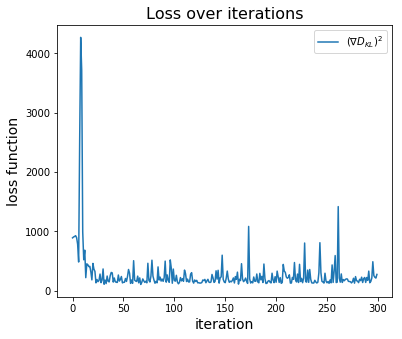

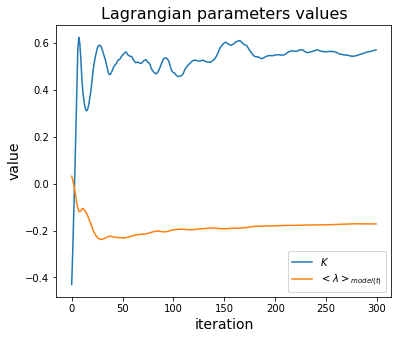

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))

plt.plot(mean_sq_loss, label= r"$(\nabla D_{KL})^2$")
plt.legend()
plt.xlabel("iteration", fontsize = 14)
plt.ylabel("loss function", fontsize = 14)
plt.title("Loss over iterations", fontsize = 16)
plt.show()
plt.close()

fig, ax = plt.subplots(ncols=1, figsize=(6,5))
plt.plot(Ks, label = r"$K$")
plt.plot(lambdas_mean, label = r"$<\lambda>_{model(t)}$")
plt.legend()
plt.xlabel("iteration", fontsize = 14)
plt.ylabel("value", fontsize = 14)
plt.title("Lagrangian parameters values", fontsize = 16)
plt.show()
plt.close()

### Theoretical estimate of K

In the pdf we show that the theoretical estimate of K must satisfy 

$$c_{obs} = \int_{-\infty}^{+\infty}dh \cdot \frac{e^{\frac{-h^2}{\sigma^2}}}{\sqrt{2\pi}\sigma} tanh(2Kc_{obs} + h)$$

$$c_{obs} = + \sqrt{\left\langle \left(\frac{S_+ - S_-}{S}\right)^2 \right \rangle} $$

In [15]:
def p_tanh_c(h, K, c, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*h**2/sigma**2)*np.tanh(2*K*c + h)

def c_minus_c(K, c, sigma):
    I = integrate.quad(func = p_tanh_c, a = -np.inf, b = np.inf, args = (K, c, sigma))[0]
    return c - I

def self_c(K, c, sigma):
    I = integrate.quad(func = p_tanh_c, a = -np.inf, b = np.inf, args = (K, c, sigma))[0]
    return I

In [19]:
from scipy import optimize
import scipy.integrate as integrate
# <(S+ - S-)^2>/S^2
c = np.sqrt(C_0_over_S/S)
print("C : %.2f"%c)
# standard deviation of the lambdas
sigma = lagrange_multipliers[1:].std()
print("Compatibility with zero: %.2f"%(np.abs(lagrange_multipliers[1:].mean())/sigma))
K_th = optimize.newton(c_minus_c, 0.3, args = (c, sigma))
print("Theoretical estimate of K: %.2f"%K_th)

C : 0.27
Compatibility with zero: 0.13
Theoretical estimate of K: 1.03


As we can see in the plot below, $K_{th}$ is the only value for which the curve $c(K)$ intersects the bisector at the value of $c_{obs}$, that is our constraint. 

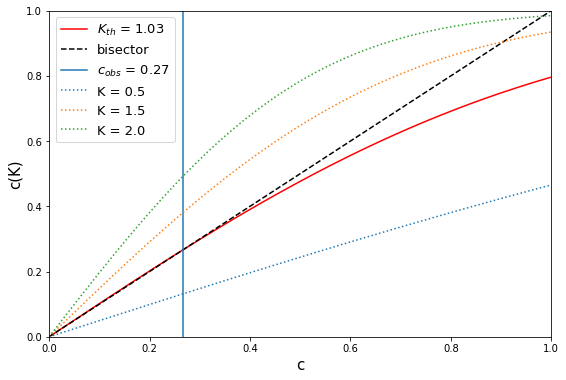

In [27]:
cs = np.linspace(0, 1, 1000)
K_values = np.array([0.5,1.5,2])
vec_c = np.vectorize(self_c)

plt.figure(figsize = (9,6))
self_cs = vec_c(K_th, cs, sigma)
plt.plot(cs, self_cs, color = 'red', label = r'$K_{th}$'+' = %.2f'%K_th)
plt.plot(cs, cs, label = 'bisector',color = 'black', linestyle = 'dashed')
plt.axvline(c, label = r'$c_{obs}$'+' = %.2f'%c)
#plt.axvline(-c, label = '-c = %.2f'%-c)

for i in range(len(K_values)):
    self_cs = vec_c(K_values[i], cs, sigma)
    plt.plot(cs, self_cs, linestyle = 'dotted', label = 'K = %.1f'%K_values[i])

plt.title("")
plt.xlabel('c', fontsize = 15)
plt.ylabel('c(K)', fontsize = 15)
plt.legend(fontsize = 13)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

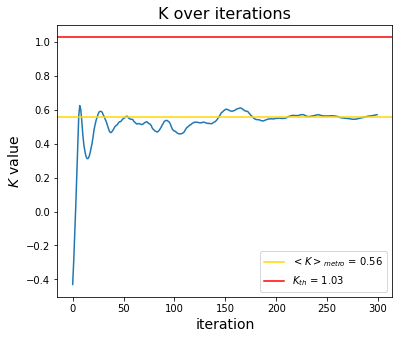

Error of the slope: 0.006


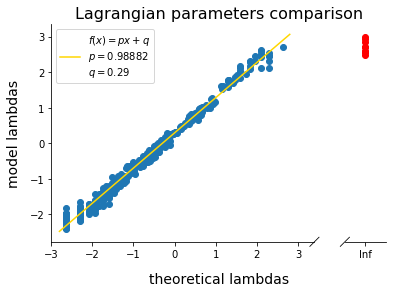

In [35]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))

ax.plot(Ks)
ax.axhline(Ks[-100:].mean(), color = 'gold',  label = r'$<K>_{metro}$'+' = %.2f'%Ks[-100:].mean())
ax.axhline(K_th, c = "red", label = r'$K_{th}$'+' = %.2f'%K_th)
ax.legend()
ax.set_xlabel("iteration", fontsize = 14)
ax.set_ylabel("$K$ value", fontsize = 14)
ax.set_title("K over iterations", fontsize = 16)
plt.show()
plt.close()

ls = np.copy(l_i)
ls[l_i>1e10] = 4 
x1 = ls[l_i<1e10]
y1 = lagrange_multipliers[1:][l_i<1e10]
x2 = ls[l_i>1e10]
y2 = lagrange_multipliers[1:][l_i>1e10]

def linear_f(x, p, q):
        return p*x+q

from scipy import optimize
params, cov = optimize.curve_fit(linear_f, x1, y1)
[p,q] = params
print("Error of the slope: %.3f"%np.sqrt(cov[0,0]))


from brokenaxes import brokenaxes
bax = brokenaxes(xlims=((-3, 3.4),(3.5, 4.5)), hspace = 1)
bax.fig.canvas.draw()

xx = np.linspace(-2.8,2.8,100)
yy = linear_f(xx, p, q)
bax.plot(xx, yy, c = "gold", label = '$f(x) = px+q$\n'+'$p = {}$'.format(round(p,5)) + '\n$q = {}$'.format(round(q,2))) 
bax.scatter(x1,y1)
bax.scatter(x2,y2, c="red")
bax.set_xlabel("theoretical lambdas", fontsize = 14)
bax.set_ylabel("model lambdas", fontsize = 14)
bax.set_title("Lagrangian parameters comparison", fontsize = 16)
bax.legend(loc=2)
ax = bax.axs[1]
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Inf'
_ = ax.set_xticklabels(labels)



### Phase diagram of the Hamiltonian

Consider as variables $K$, $\sigma = \sqrt{\frac{ \sum_{i=1}^S (\lambda_i - <\lambda>)^2}{S-1}}$ and $\beta = \frac{1}{T}$.

Defining $\hat{K} = \frac{K}{\sigma}$, $\hat{\lambda} = \beta \lambda$ and $\hat{\beta} = \sigma \beta$ one can show that for each $\hat{\beta}$ there is a $\hat{K}$ for which the Hamiltonian of section 4 is at a phase transition between the paramagnetic and the ferromagnetic phase. 

The equation of the curve of phase transition is 
$$2\hat{K} = \left(\int_{-\infty}^{+\infty}\frac{d\hat{\lambda}}{\sqrt{2\pi}} \frac{e^{(-\hat{\lambda}^2/2\hat{\beta}^2)}}{cosh(\hat{\lambda})^2} \right)^{-1}$$

In [36]:
def f1(h, beta_hat):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*h**2/beta_hat**2)/np.cosh(h)**2
    
def K_hat_beta_hat(beta_hat):
    I = integrate.quad(func = f1, a = -np.inf, b = np.inf, args = (beta_hat))[0]
    return 0.5/I

vec_K_hat = np.vectorize(K_hat_beta_hat)    

In [37]:
beta_hats = np.linspace(0.25, 1000, 10000)
K_hats =vec_K_hat(beta_hats)
T_hats = 1./beta_hats

/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in cosh
  


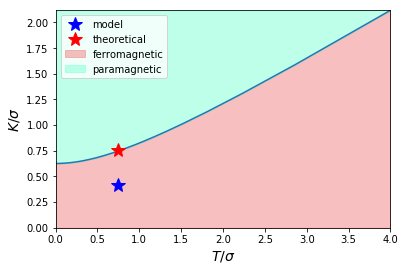

In [38]:
plt.plot(T_hats, K_hats)
ceiling = np.full(len(K_hats), K_hats.max())
plt.fill_between(T_hats, 0, K_hats, color = 'lightcoral' , alpha = 0.5, label = "ferromagnetic")
plt.fill_between(T_hats, K_hats, ceiling, color = 'aquamarine', alpha = 0.5, label = "paramagnetic")
plt.xlim(0,4)
plt.ylim(0,K_hats.max())

sigma = lagrange_multipliers[1:].std()
plt.plot(1/sigma, Ks[-10:].mean()/sigma, 'b*', markersize = 14, label = "model" )
plt.plot(1/sigma, K_th/sigma, 'r*', markersize = 14, label = "theoretical" )
plt.xlabel(r'$T/\sigma$', fontsize = 14)
plt.ylabel(r'$K/ \sigma$', fontsize = 14)
plt.legend()
plt.show()

## 6 - Max Ent 3

$ H = \sum_{i=1}^S \lambda_i x_i + \frac{1}{2}\sum_{i,j=1}^S M_{ij}x_i x_j$

$M_{ij}^{-1} = Cov(x_i,x_j)_{emp}$

$\lambda_i = - \sum_{j=1}^S M_{ij}x_j$

First of all we consider the matrix X of all the aboundances for all the subplots. It is a matrix of N rows and S columns.

In [39]:
X = cell_pop_M.reshape((200,299))

Then we compute for each species the mean and the standard deviation

In [40]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)

We keep only those species that satisfy:

$<x_i>_{emp} - \sigma_{x_i} > 0$

In [41]:
aboundance_mask = x_mean - x_std > 0 
X_most_ab = X[:,aboundance_mask]

In this way we reduce the number of species from 299 to 52:

In [42]:
print(X_most_ab.shape[1])

52


Now we compute the inverse of the interaction matrix M as the covariance matrix of the abundances of the selected species and from that we obtain M inverting $M^{-1}$

In [43]:
inv_M = np.cov(X_most_ab.T)
M = np.linalg.inv(inv_M)

We now impose that the self interacting terms (diagonal) are null

In [44]:
mask = np.eye(M.shape[0]).astype('bool')
M[mask] = 0
print(M.trace())

0.0


In [45]:
print("Max interaction element: %.3f"%M.max())
print("Min interaction element: %.3f"%M.min())

Max interaction element: 0.176
Min interaction element: -0.093


At this point we can compute $\lambda_i$ with the formula reported at the begin of this section

In [46]:
X_most_mean = X_most_ab.mean(axis = 0)
lamb = -np.dot(M,X_most_mean)
#plt.hist(lamb)
#plt.show()
#plt.close()

# 7 - Analysis of the interaction network

In this first histogram we can see the distribuition of the entries of the matrix $M$. We can notice that the distribution is peaked around the zero (with a number of entries much higher than the length of the diagonal, i.e. ~600 vs 52) and it is more or less symmetric around zero.

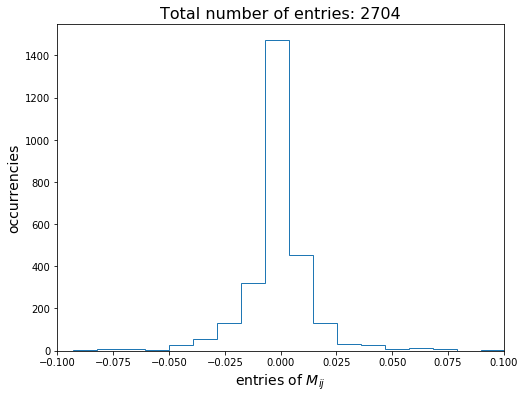

In [47]:
plt.figure(figsize = (8,6))
plt.hist(M.flatten(), bins = 25, histtype = 'step', density = False)
plt.xlim(-0.10, +0.10)
plt.xlabel("entries of $M_{ij}$", fontsize = 14)
plt.ylabel("occurrencies", fontsize = 14)
plt.title("Total number of entries: %d"%(len(M)**2), fontsize = 16)
plt.show()

Now we want to put a threshold $\theta$ on the absolute value of the entries of M. We choose as range for the threshold $[0,max(abs(M))]$

In [48]:
def laplacian(A):
    degrees = A.sum(axis = 0)
    K = np.diag(degrees)
    return K-A

In [49]:
# number of threshold we want to use
T = 2000
# consider evenly spaced thresholds
thresholds = np.linspace(0, np.max(np.abs(M)), T)
# placehholder for the number of connected components for each threshold
connected_components = np.zeros(T)
# this is the order of magnitude under which we consider zero an eigenvalue
sensibility = 10**-12 
#OBS: it can't be taken too small otherwise it would count 0 connected components for theta = 0, that is absurd

for i,theta in enumerate(thresholds):
    # elementwise boolean operation, returns a matrix of True and False
    threshold_mask = np.abs(M) > theta 
    # we can compute directly the adjacency matrix from the threshold mask
    A = threshold_mask.astype(int)
    # compute the laplacian of A
    L = laplacian(A)
    # eigenvalue decomposition; "eigh" used for symmetric matrix -> default format fo eigenvalues is set to float
    eig_values,V = np.linalg.eigh(L)
    # we take as zero all the eigenvalues with absolute value under the chosen sensibility 
    almost_zero = np.abs(eig_values) < sensibility
    # number of conncected components = number of zero eigenvalues (or equivalently degeneracy of eigval 0)
    connected_components[i] = np.count_nonzero(almost_zero.astype(int))

In [50]:
one_component_mask = connected_components == 1
theta_star = np.max(thresholds[one_component_mask])
print("Estimated theta star: %.4f"%theta_star)

Estimated theta star: 0.0031


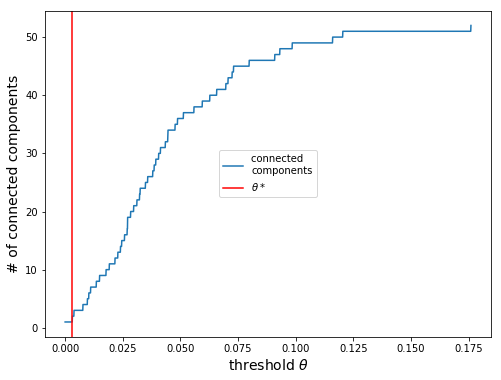

In [51]:
plt.figure(figsize = (8,6))
plt.plot(thresholds, connected_components, label = 'connected \ncomponents')
plt.xlabel("threshold "+r"$\theta$", fontsize = 14)
plt.ylabel("# of connected components", fontsize = 14)
plt.axvline(theta_star, color = 'red', label = r'$\theta*$')
plt.legend(loc = 'center')
plt.show()

In [52]:
# if we are interested in the detailed correspondence between threshold and connected components
for t,c in zip(thresholds, connected_components):
    print("Threshold = %.4f, connected components = %.d"%(t,c))

Threshold = 0.0000, connected components = 1
Threshold = 0.0001, connected components = 1
Threshold = 0.0002, connected components = 1
Threshold = 0.0003, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0005, connected components = 1
Threshold = 0.0006, connected components = 1
Threshold = 0.0007, connected components = 1
Threshold = 0.0008, connected components = 1
Threshold = 0.0009, connected components = 1
Threshold = 0.0010, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0012, connected components = 1
Threshold = 0.0013, connected components = 1
Threshold = 0.0014, connected components = 1
Threshold = 0.0015, connected components = 1
Threshold = 0.0016, connected components = 1
Threshold = 0.0017, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold 

Threshold = 0.1506, connected components = 51
Threshold = 0.1506, connected components = 51
Threshold = 0.1507, connected components = 51
Threshold = 0.1508, connected components = 51
Threshold = 0.1509, connected components = 51
Threshold = 0.1510, connected components = 51
Threshold = 0.1511, connected components = 51
Threshold = 0.1512, connected components = 51
Threshold = 0.1513, connected components = 51
Threshold = 0.1513, connected components = 51
Threshold = 0.1514, connected components = 51
Threshold = 0.1515, connected components = 51
Threshold = 0.1516, connected components = 51
Threshold = 0.1517, connected components = 51
Threshold = 0.1518, connected components = 51
Threshold = 0.1519, connected components = 51
Threshold = 0.1520, connected components = 51
Threshold = 0.1520, connected components = 51
Threshold = 0.1521, connected components = 51
Threshold = 0.1522, connected components = 51
Threshold = 0.1523, connected components = 51
Threshold = 0.1524, connected comp

In [53]:
import networkx as nx

In [54]:
threshold_mask = np.abs(M) > theta_star
# this is the adjacency matrix that we are going to use for our analysis
A_star = threshold_mask.astype(int)

Analyze the structural properties of W * (degree distribution, diameter, clustering, degree assortativity, betweeness centrality). In what respect, if any, the graph is different from a random ER graph?

Mean degree: 30.42
Degree standard deviation: 10.28


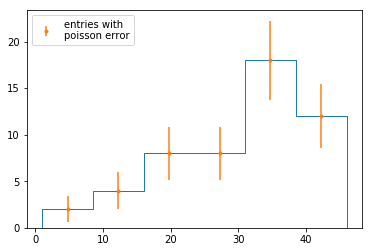

In [55]:
K = A_star.sum(axis = 0)
print("Mean degree: %.2f"% K.mean())
print("Degree standard deviation: %.2f"% K.std())
# not having much elements for a graphs we prefer to use a small amount of bins 
# in order to capture less information but more reliable
entries, bin_extremes, _ = plt.hist(K, bins = 6, histtype = 'step')
bin_centers = (bin_extremes[1:] + bin_extremes[:-1])/2
plt.errorbar(bin_centers, entries, yerr = np.sqrt(entries), fmt = '.', label = 'entries with \npoisson error')
plt.legend(loc = "upper left")
plt.show()

Using the networkx library we can easily compute most of the quantities of interest.

In [56]:
G = nx.from_numpy_matrix(A_star)

D = nx.diameter(G)
print("Diameter of the network: ", D)

# local clustering for each node
c_i_dict = nx.clustering(G)
n_nodes = len(G)
c_i = np.zeros(n_nodes)
for i in range(n_nodes):
    c_i[i] = c_i_dict[i]
    
# global clustering
C = c_i.mean()
print("Global clustering coefficient: %.2f"% C)

deg_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: %.2f"%deg_assortativity)

btw_centrality = nx.betweenness_centrality(G)
b_c = np.zeros(n_nodes)
for i in range(n_nodes):
    b_c[i] = btw_centrality[i]
print("Max beetweenness centrality: %.2f"%b_c.max())

Diameter of the network:  3
Global clustering coefficient: 0.73
Degree assortativity: -0.24
Max beetweenness centrality: 0.05


We can compare these results with the one that we would find in an Erdosh-Reny graph with the same number of nodes and with probability of connecting two nodes given by $p = \frac{<k>}{n-1}$, where $<k>$ is the observed average degree of $A^*$. To do this, we consider an ensamble of E-R graphs in order to compute the estimated quantities and not the one of a single realization.

In [57]:
p = K.mean()/(n_nodes-1)
graphs_number = 100

# we are going to store in the following arrays all the results for each single ER graph 
# and then make a statistic out of them
ER_k_std_devs = np.zeros(graphs_number)
ER_diameters = np.zeros(graphs_number)
ER_cluster_coeffs = np.zeros(graphs_number)
ER_deg_assortativities = np.zeros(graphs_number)
ER_max_btw_centralities = np.zeros(graphs_number)


for i in range(graphs_number):
    # create an Erdosh-Reny graph
    ERG = nx.gnp_random_graph(n_nodes,p)
    # compute the degree standard deviation
    degs_dict = ERG.degree()
    degs = np.zeros(n_nodes)
    for j in range(n_nodes):
        degs[j] = degs_dict[j]
    ER_k_std_devs[i] = degs.std()
    
    ER_diameters[i] =  nx.diameter(ERG)
    
    c_i_dict = nx.clustering(ERG)
    c_i = np.zeros(n_nodes)
    for j in range(n_nodes):
        c_i[j] = c_i_dict[j]

    # global clustering
    ER_cluster_coeffs[i] = c_i.mean()

    ER_deg_assortativities[i] = nx.degree_assortativity_coefficient(ERG)

    btw_centrality = nx.betweenness_centrality(ERG)
    b_c = np.zeros(n_nodes)
    for j in range(n_nodes):
        b_c[j] = btw_centrality[j]
    ER_max_btw_centralities[i] = b_c.max()

print("Degree standard deviation: %.2f"% ER_k_std_devs.mean())
print("Diameter of the network: %.2f" % ER_diameters.mean())
print("Global clustering coefficient: %.2f"% ER_cluster_coeffs.mean())
print("Degree assortativity: %.2f"%ER_deg_assortativities.mean())
print("Max beetweenness centrality: %.2f"%ER_max_btw_centralities.mean())

Degree standard deviation: 3.42
Diameter of the network: 2.00
Global clustering coefficient: 0.60
Degree assortativity: -0.04
Max beetweenness centrality: 0.01


Confronting the results of the real network with the ensamble of ER graphs:

| Quantity | Real graph | ER graph|
| --- | --- | --- |
| degree std dev | 10.28 | 3.38 |
| diameter | 3 | 2.00 |
| clustering | 0.73| 0.59 |
| assortativity | -0.24 | -0.04 |
| max centrality | 0.05 | 0.01 |

We can see that none of these quantities is too similar between the two kinds of graphs. 

More precisely we can conclude that our network:
* presents a much higher variance in the degree distribution;
* has a larger diameter (ER diameter being 2.00 for a hundred graphs imply that none of them has diameter equal 3!);
* has a higher clustering coefficient;
* has a disassortative behaviour w.r.t. the almost neutral one of the ER ensamble;
* has a central node with a betweenness centrality that is 5 times higher than the "central" node of ER graphs.

All this suggests that the network of the species has an underlying structure that is not random, but possibly depends on the "microscopic" details of each species.

NOTE: ER results could vary a bit because we don't have a fixed seed for their generator.